In [1]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.sys.path.append('../src')
from helpers import resize_to_fit

In [3]:
letters_dir = '../data/letters'

In [4]:
LETTER_IMAGES_FOLDER = letters_dir

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 32, 32)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-1].split('.')[-2].split('-')[1]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


In [5]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [6]:
# Split the training data into separate train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [7]:
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 10
log_interval = 10

In [8]:
X_train_t = (torch.from_numpy(X_train).float().transpose(1,3)).transpose(2,3)
y_train_t = torch.from_numpy(y_train).long()

train_data = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=round(batch_size_train), shuffle=True)

In [9]:
X_test_t = (torch.from_numpy(X_test).float().transpose(1,3)).transpose(2,3)
y_test_t = torch.from_numpy(y_test).long()

test_data = torch.utils.data.TensorDataset(X_test_t, y_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

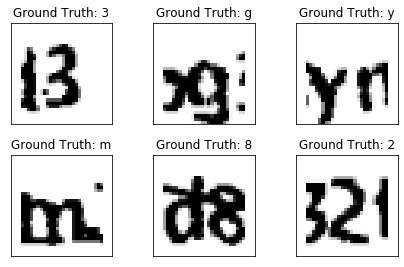

In [11]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(le.inverse_transform(example_targets)[i]))
    plt.xticks([])
    plt.yticks([])

In [12]:
class Net(nn.Module):
    def __init__(self, H, D):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, H)
        self.fc2 = nn.Linear(H, 32)
        self.dropout = nn.Dropout(D)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=0)

In [13]:
net = Net(120, 0.3)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [14]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [15]:
def train(epoch, v=True):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [52]:
def test(v = 0):
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    if v:
        print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc = correct.item()
    return acc

In [45]:
n_epochs = 30
test(1)
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test(1)

Test set: Avg. loss: 4.5543, Accuracy: 1096/1338 (81%)

tensor(1096)


AttributeError: 'Tensor' object has no attribute 'real'

ValueError: x and y must be the same size

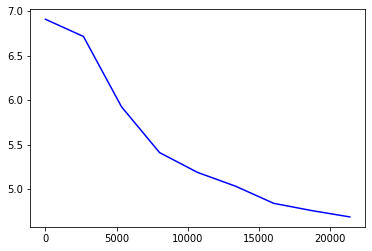

In [46]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

Net with H = 60, D = 0
Net with H = 60, D = 0
Net with H = 60, D = 0
Avg accuracy: 0.8718859459356724


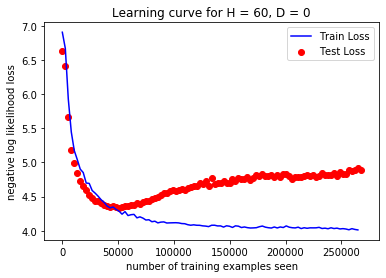

Net with H = 60, D = 0.3
Net with H = 60, D = 0.3
Net with H = 60, D = 0.3
Avg accuracy: 0.9197431279228757


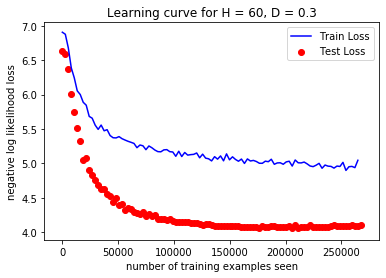

Net with H = 60, D = 0.5
Net with H = 60, D = 0.5
Net with H = 60, D = 0.5
Avg accuracy: 0.9008095823182809


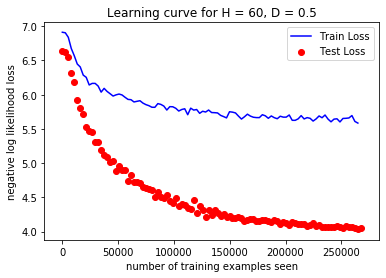

Net with H = 120, D = 0
Net with H = 120, D = 0
Net with H = 120, D = 0
Avg accuracy: 0.8995522030410393


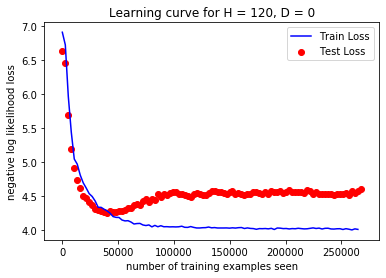

Net with H = 120, D = 0.3
Net with H = 120, D = 0.3
Net with H = 120, D = 0.3
Avg accuracy: 0.9444187304046906


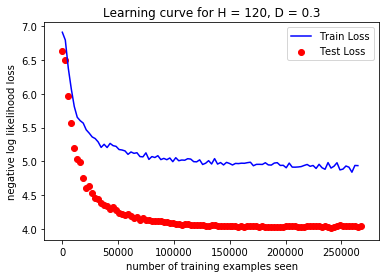

Net with H = 120, D = 0.5
Net with H = 120, D = 0.5
Net with H = 120, D = 0.5
Avg accuracy: 0.949901597214536


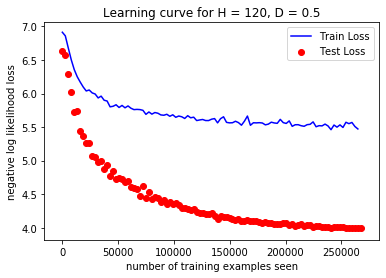

Net with H = 340, D = 0
Net with H = 340, D = 0
Net with H = 340, D = 0
Avg accuracy: 0.904790600139601


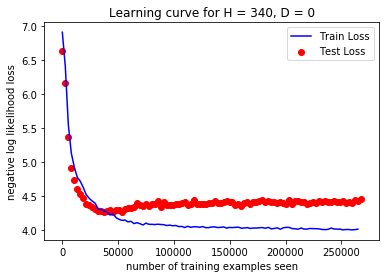

Net with H = 340, D = 0.3
Net with H = 340, D = 0.3
Net with H = 340, D = 0.3
Avg accuracy: 0.9541390100989094


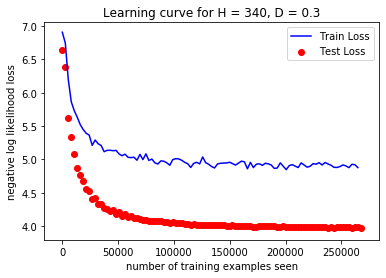

Net with H = 340, D = 0.5
Net with H = 340, D = 0.5
Net with H = 340, D = 0.5
Avg accuracy: 0.9381877341049036


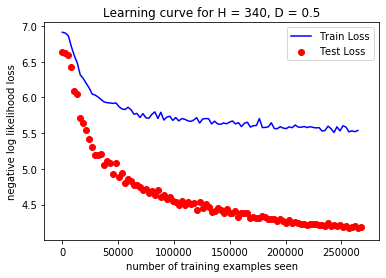

In [55]:
n_epochs = 100
cv = KFold()
global acc

for H in [60, 120, 340]:
    for D in [0, 0.3, 0.5]:
        acc_avg = 0
        for mask_train, mask_test in cv.split(X_train_t):
            
            test_data = torch.utils.data.TensorDataset(X_train_t[mask_test], y_train_t[mask_test])
            test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)
            
            train_data = torch.utils.data.TensorDataset(X_train_t[mask_train], y_train_t[mask_train])
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_test, shuffle=True)
             
            net = Net(H, D)
            optimizer = optim.Adam(net.parameters(), lr=learning_rate)

            train_losses = []
            train_counter = []
            test_losses = []
            test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

            print("Net with H = {}, D = {}".format(H, D))

            acc = test(0)
            max_acc = acc
            for epoch in range(1, n_epochs + 1):
                train(epoch, False)
                acc = test(0)
                if acc > max_acc:
                    max_acc = acc
            
            acc_avg += max_acc/len(test_loader.dataset)
        
        print("Avg accuracy: {}".format(acc_avg/3))

        fig = plt.figure()
        plt.plot(train_counter, train_losses, color='blue')
        plt.scatter(test_counter, test_losses, color='red')
        plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('number of training examples seen')
        plt.ylabel('negative log likelihood loss')
        plt.title('Learning curve for H = {}, D = {}'.format(H, D))
        plt.show()   